
![Py4Eng](img/logo.png)

# Optimization
## Yoav Ram

In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import scipy
import scipy.optimize as opt
import scipy.special as spec
import seaborn as sns
sns.set_theme(
    style='ticks',
    context='notebook' 
)

# Optimization

*Scipy* has several methods for optimizing (minimizing or maximizing) functions.

This session is roughly based on [Tutorial on "Modern Optimization Methods in Python" ](https://github.com/mmckerns/tutmom/blob/aae5de033cbbf7565f196fc8e92181fe0bbe9926/intro.ipynb).

## Simple minimization

Consider the following polynomial, defined using `np.poly1d1`, which, given the polynomial coeffcients $a_i$ returns a polynomial $\sum_{i=0}^n{a_i x^i}$:

In [2]:
p = np.poly1d((1.3, 4, 0.6))
print(p)

     2
1.3 x + 4 x + 0.6


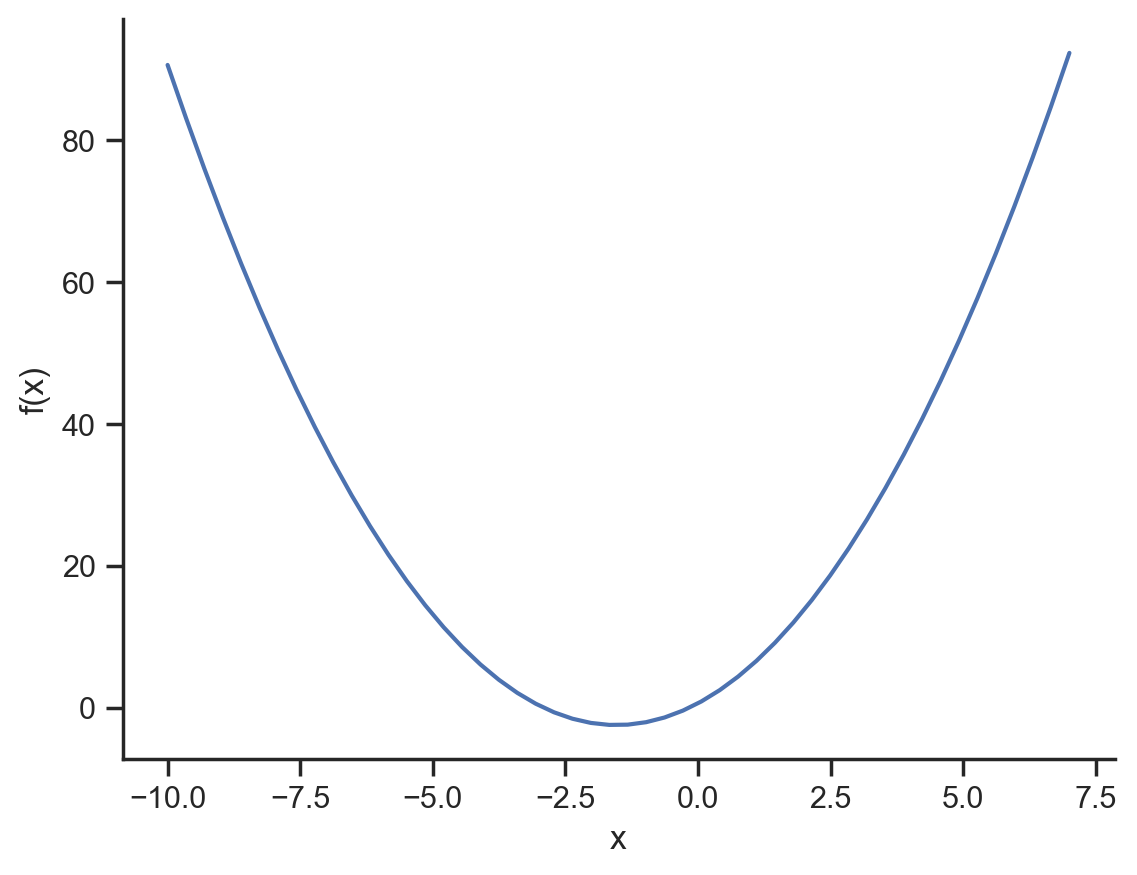

In [3]:
def minplot(x, f, xmin=None):
    plt.plot(x, f(x))
    if xmin is not None:
        plt.plot(xmin, f(xmin), 'ok')
        plt.axvline(xmin, color='k', ls='--')
    plt.xlabel('x')
    plt.ylabel('f(x)')
    sns.despine()

x = np.linspace(-10, 7)
minplot(x, p)

We'll use `scipy.optimize.fmin` (aliasing `scipy.optimize` as `opt`) to find a minimum for `p`, our polynomial. `fmin` uses the *downhill simplex algorithm* and we start with the guess 3:

Optimization terminated successfully.
         Current function value: -2.476923
         Iterations: 20
         Function evaluations: 40
x = [-1.53845215], p(x) = [-2.47692308]


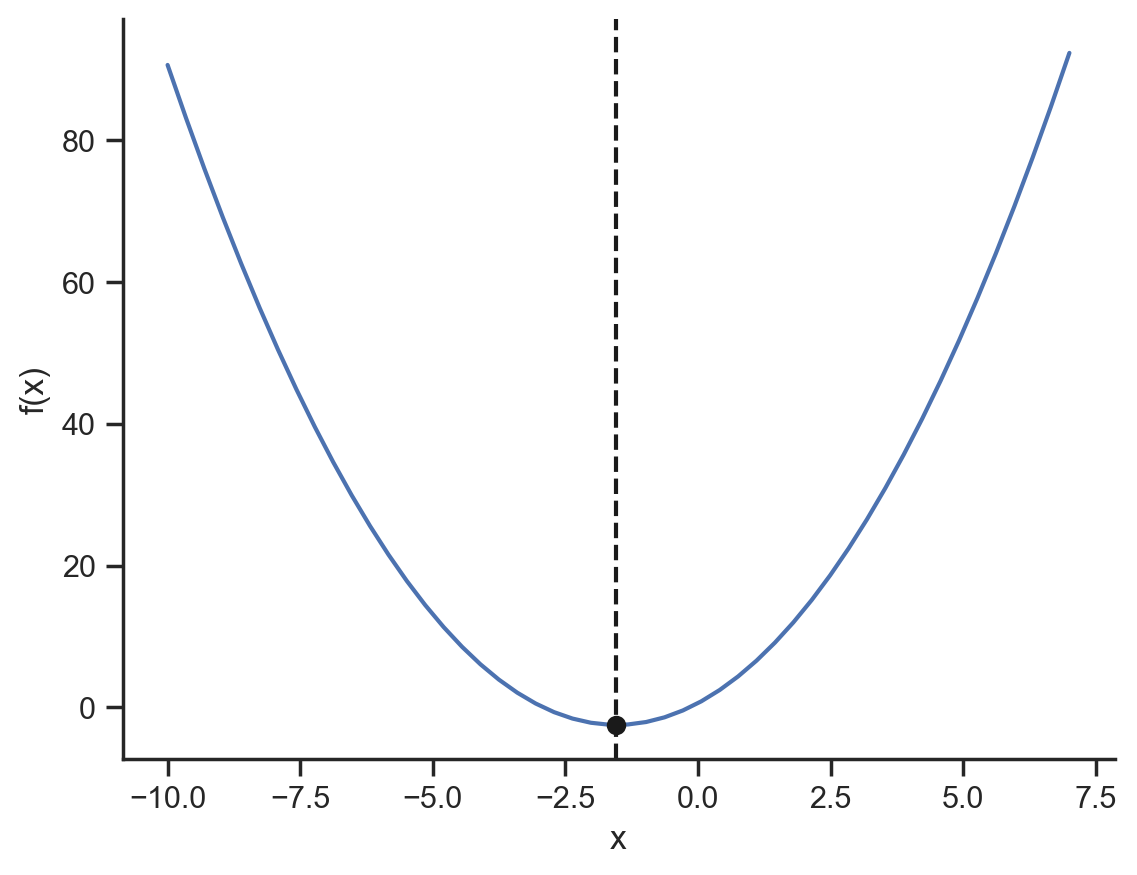

In [4]:
xmin = opt.fmin(p, [3])
print("x = {0}, p(x) = {1}".format(xmin, p(xmin)))
minplot(x, p, xmin)

## Exercise 1

Find the minimum of the function $f(x) = (x-2)(x+1)^3$ using either `fmin` or `minimize_scalar`. The later doesn't require a guess (`x0`).

In [5]:
# your code here

f(1.2500000110983318)=-8.54296875


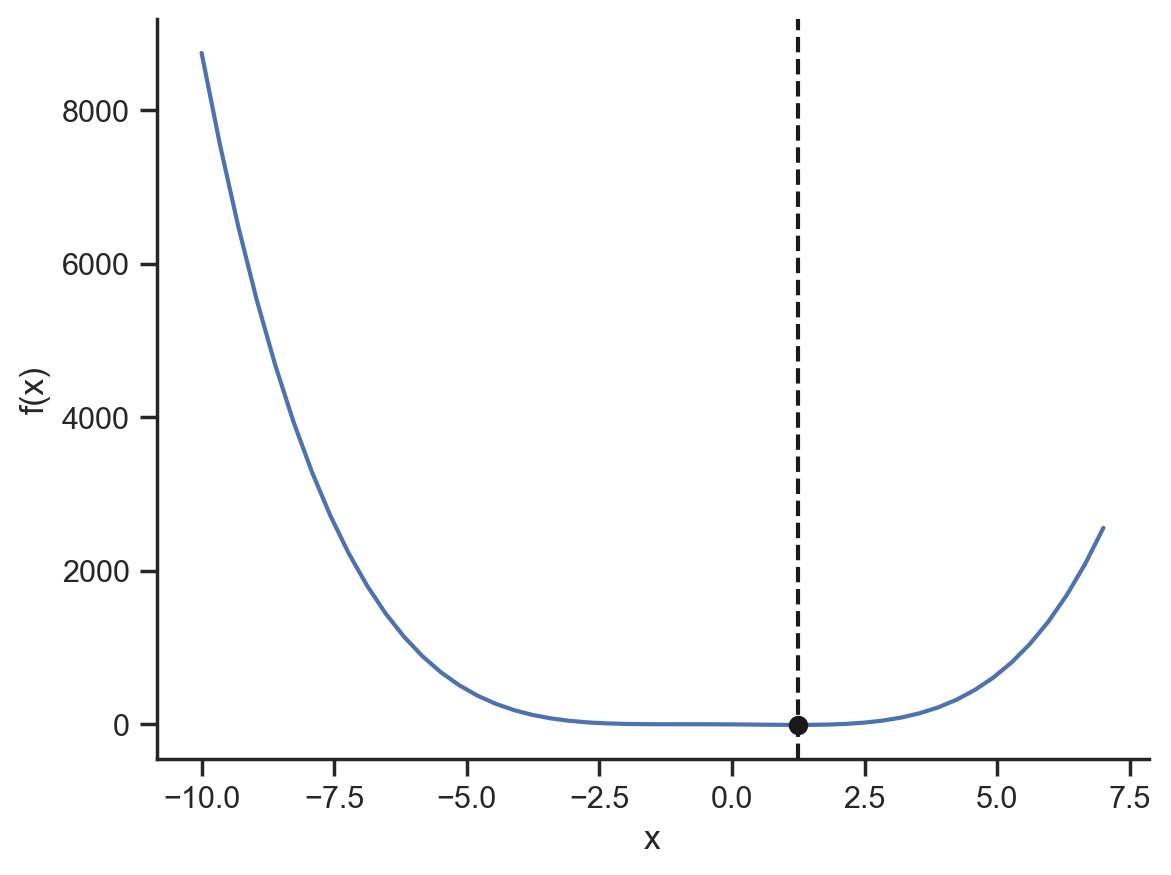

In [6]:
minplot(x, f, x0)

## Minimizing with "box" constraints

Suppose we want to find the minimum of a 1st order Bessel function with the constraint $8<x<16$:

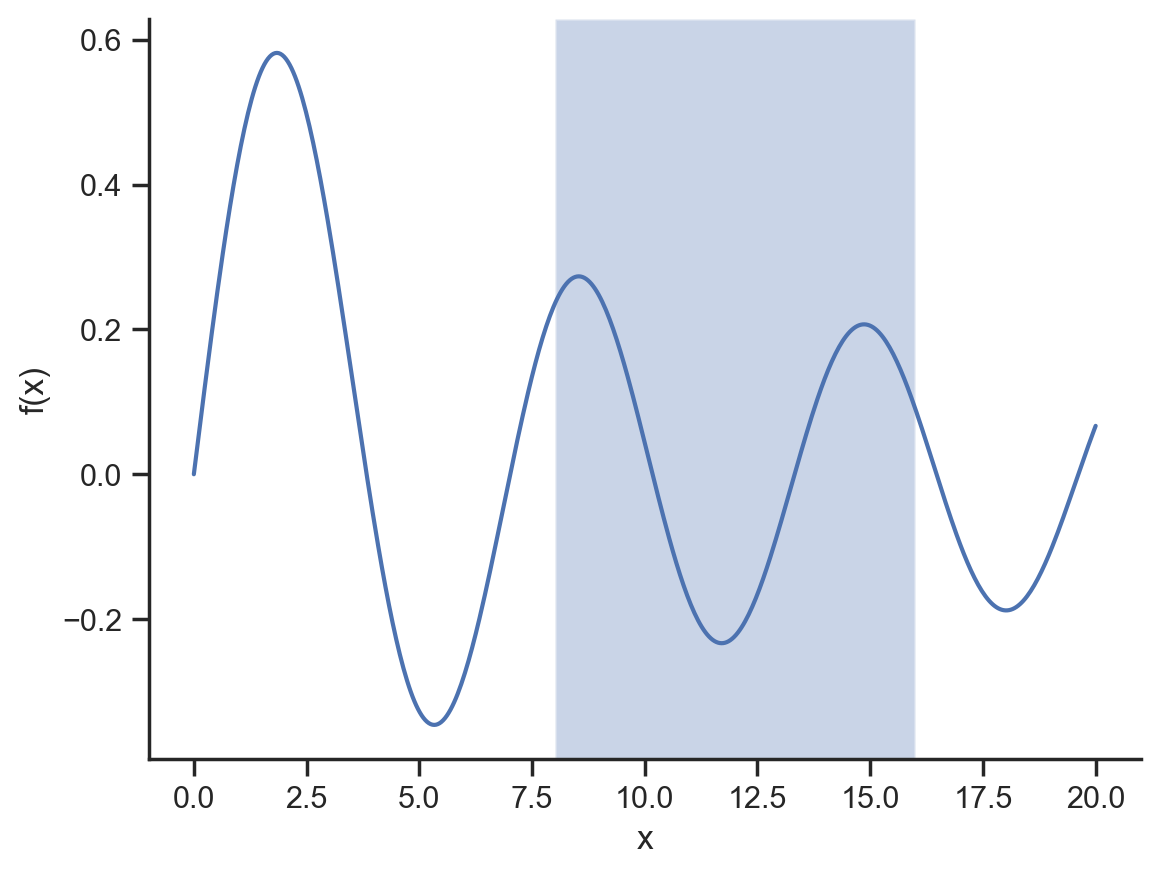

In [8]:
x = np.linspace(0, 20, 500)
minplot(x, spec.j1)
plt.axvspan(8, 16, alpha=0.3);

We use `opt.minimize_scalar` and give it constraints:

     fun: -0.23330441717143405
 message: 'Solution found.'
    nfev: 9
     nit: 9
  status: 0
 success: True
       x: 11.706004881285123


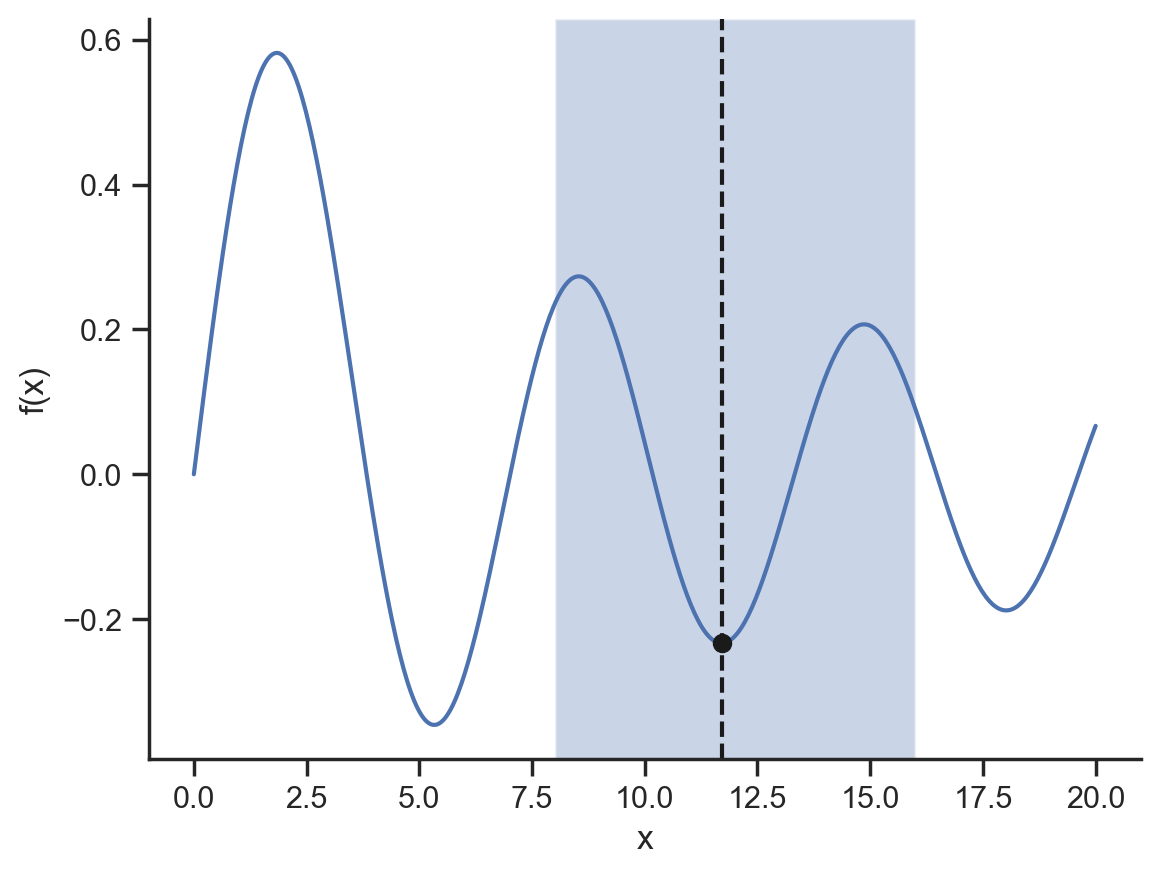

In [9]:
result = opt.minimize_scalar(spec.j1, method="bounded", bounds=[8, 16])
print(result)
minplot(x, spec.j1, result.x)
plt.axvspan(8, 16, alpha=0.3);

## Exercise 2

Find the **maximum** of the *Fresnel sin integral*, which is the first value returned from the $\mathbb R \to \mathbb R^2$ function [`scipy.special.fresnel`](http://docs.scipy.org/doc/scipy/reference/generated/scipy.special.fresnel.html#scipy.special.fresnel). Constrain maximization to $x \in (2, 3)$. Plot the result and the maximum to make sure you got it right.

     fun: -0.6289396585373808
 message: 'Solution found.'
    nfev: 9
     nit: 9
  status: 0
 success: True
       x: 2.449488900303877


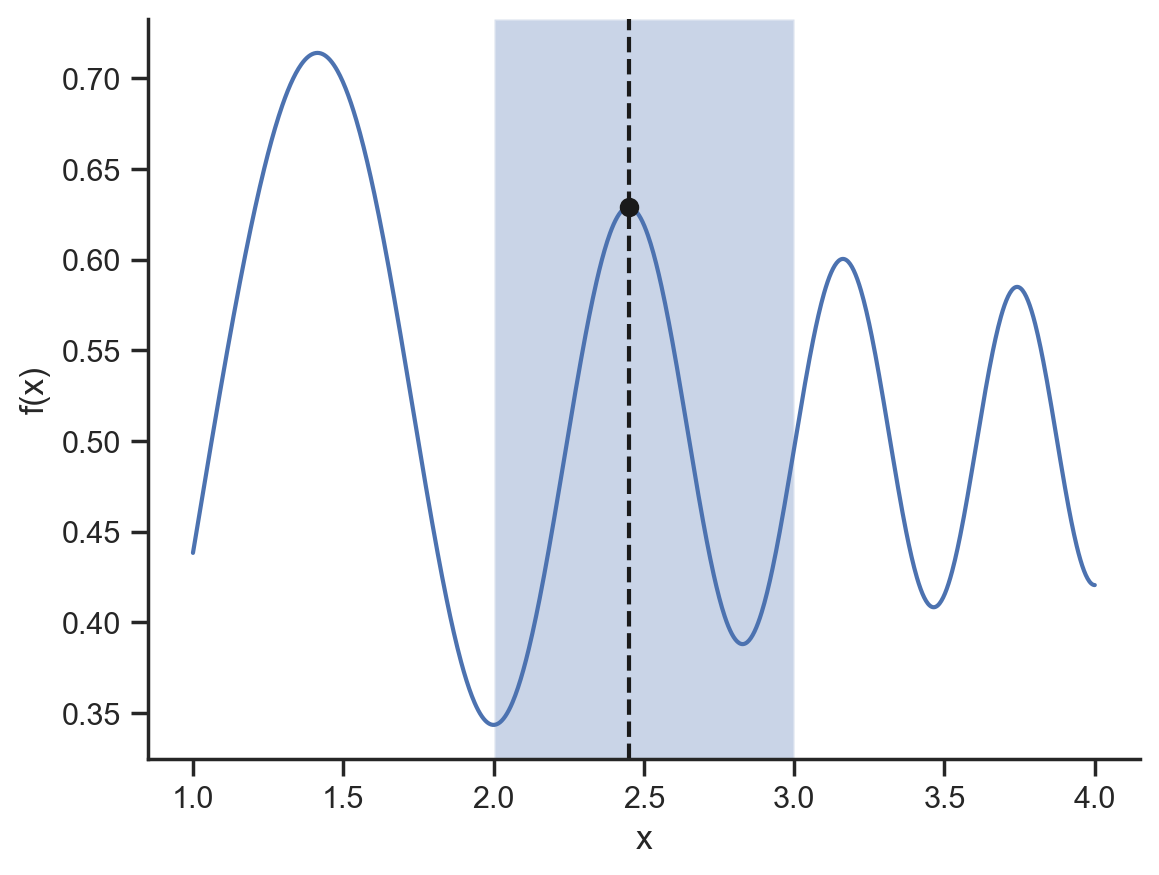

# Minimize a multivariate function

Follows example from [SciPy Tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#tutorial-sqlsp).

The `opt.minimize` provides interface to other contrained methods. Let's use *SLSQP* (Sequential Least SQuares Programming) method to deal with the following problem:

$$
f(x,y) = 2xy + 2x - x^2 -2y^2 \\
x^3 = y \\
y \ge 1
$$


In [34]:
def f(xy):
    x, y = xy
    return 2 * x * y + 2 * x - x**2 - 2 * y**2

def negf(xy):
    return -f(xy)

x = np.linspace(-5, 5)
y = np.linspace(-5, 5)

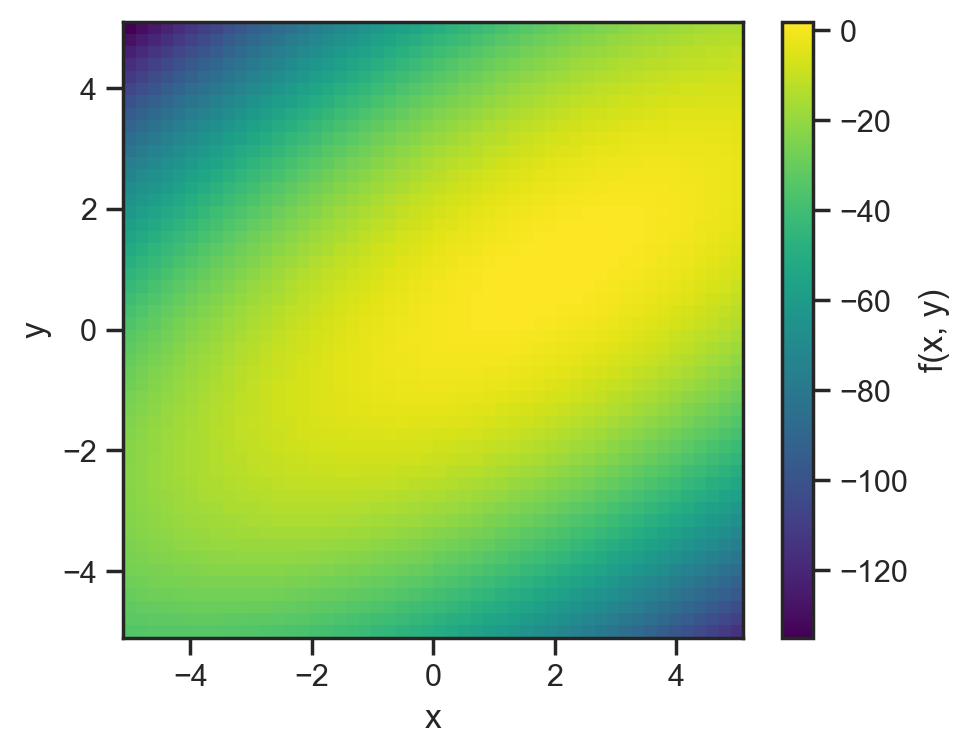

In [45]:
def minplot3d(x, y, f, xmin=None, ymin=None):
    grid = np.meshgrid(x, y)
    z = f(grid)
    plt.figure(figsize=(5, 4))
    plt.pcolormesh(x, y, z, cmap='viridis')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.colorbar(label='f(x, y)')
    if xmin is not None and ymin is not None:
        plt.scatter(xmin, ymin, s=50, c='k')
        
minplot3d(x, y, f)

For this method we also need the derivative of `f` with respect to `x` and `y`:

In [43]:
def df(xy):
    x, y = xy
    dfdx = -2*x + 2*y + 2
    dfdy = 2*x - 4*y
    return dfdx, dfdy

def negdf(xy):
    dfdx, dfdy = df(xy)
    return -dfdx, -dfdy

Now an **unconstrained optimization** can be performed as:

Optimization terminated successfully    (Exit mode 0)
            Current function value: -2.0
            Iterations: 4
            Function evaluations: 5
            Gradient evaluations: 4
     fun: -2.0
     jac: array([-0., -0.])
 message: 'Optimization terminated successfully'
    nfev: 5
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([2., 1.])
Min at  [2. 1.]


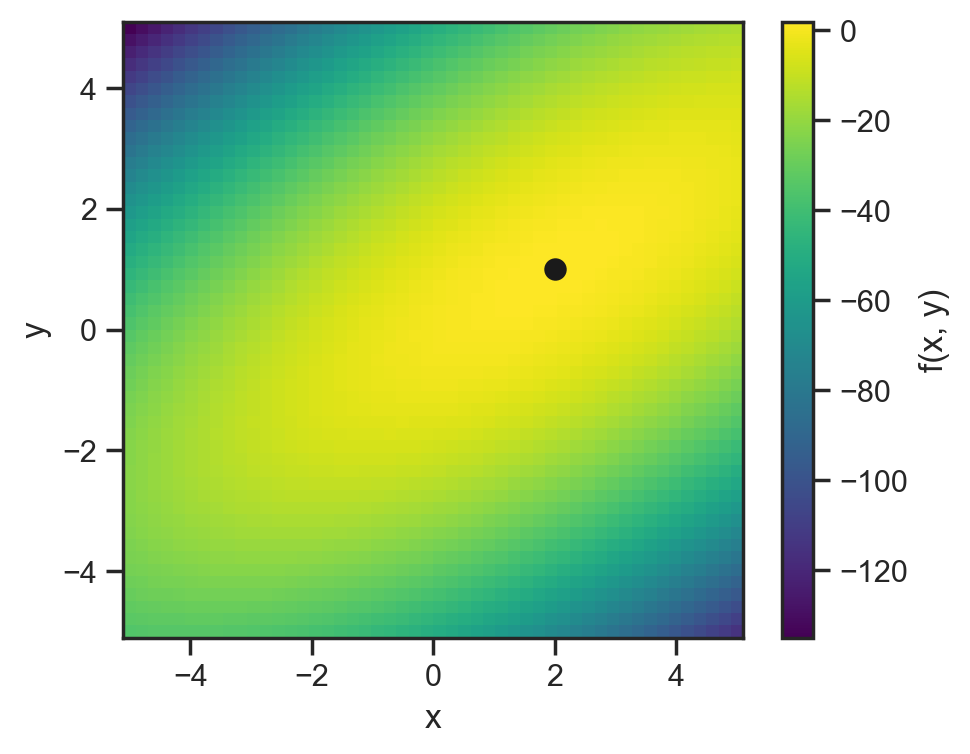

In [55]:
res = opt.minimize(
    negf, 
    x0=[-1, 1],
    jac=negdf,
    method='SLSQP', 
    options={'disp': True}
)
print(res)
print("Min at ", res.x)
xmin, ymin = res.x
minplot3d(x, y, f, xmin, ymin)

Then constraints are defined as a sequence of dictionaries, with keys `type`, `fun` and `jac`. Reminder:

$$
x^3 = y \Rightarrow x^3 - y = 0 \\
y \ge 1 \Rightarrow y - 1 \ge 0
$$

If we had a $<=$ inequality, we would have multiplied both sides by -1.

In [56]:
cons = (
    dict(
        type='eq',
        fun=lambda v: [v[0]**3 - v[1]], # v[0] -> x, v[1] -> y
        jac=lambda v: [3 * (v[0]**2), -1]
    ),
    dict(
        type='ineq',
        fun=lambda v: [v[1] - 1],
        jac=lambda v: [0, 1]
    )
)

In [57]:
res = opt.minimize(
    negf, 
    x0=[-1, 1],
    jac=negdf,
    constraints=cons,
    method='SLSQP', 
    options={'disp': True}
)
print(res)
print()
print("Min at ", res.x)
xmin_const, ymin_const = res.x
print(xmin_const**3 - ymin_const)
print(ymin_const - 1)

Optimization terminated successfully    (Exit mode 0)
            Current function value: -1.0000001831052137
            Iterations: 9
            Function evaluations: 14
            Gradient evaluations: 9
     fun: -1.0000001831052137
     jac: array([-1.99999982,  1.99999982])
 message: 'Optimization terminated successfully'
    nfev: 14
     nit: 9
    njev: 9
  status: 0
 success: True
       x: array([1.00000009, 1.        ])

Min at  [1.00000009 1.        ]
2.746578582346615e-07
0.0


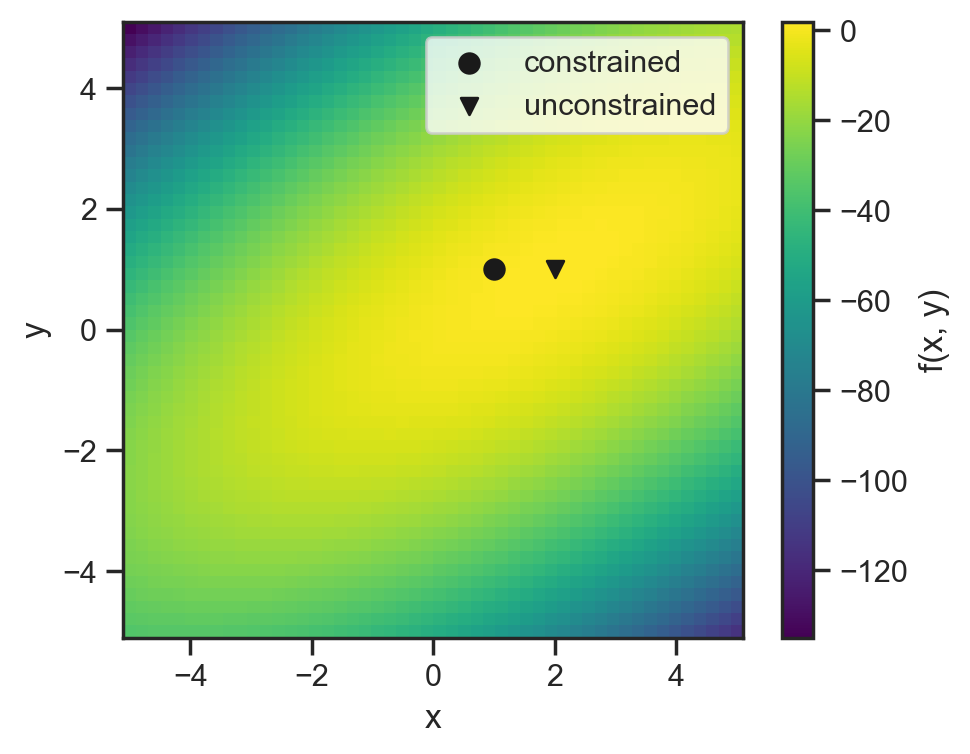

In [61]:
minplot3d(x, y, f, xmin_const, ymin_const)
plt.scatter(xmin, ymin, marker='v', color='k')
plt.legend(['constrained', 'unconstrained']);

## Exercise 3

Minimize the Rosenbrock function:
$$
f(x) = \sum_{i=1}^{N-1}{100(x_i - x_{i-1}^2)^2 + (1-x_{i-1})^2}
$$
defined in `opt.rosen` as a function that accepts an array `x`.

Use how many dimensions you want (determined by the initial guess), use the function `opt.minimize` with `method` set to either `nelder-mead` or `powell`.

The result should be an array of `1`s. If you get something close but not quite, you can change the tolerance by giving `opt.minimize` the argument `options={'xtol':tol}`, where `tol` is the error tolerance you want.

     fun: -0.6289396585373808
 message: 'Solution found.'
    nfev: 9
     nit: 9
  status: 0
 success: True
       x: 2.449488900303877


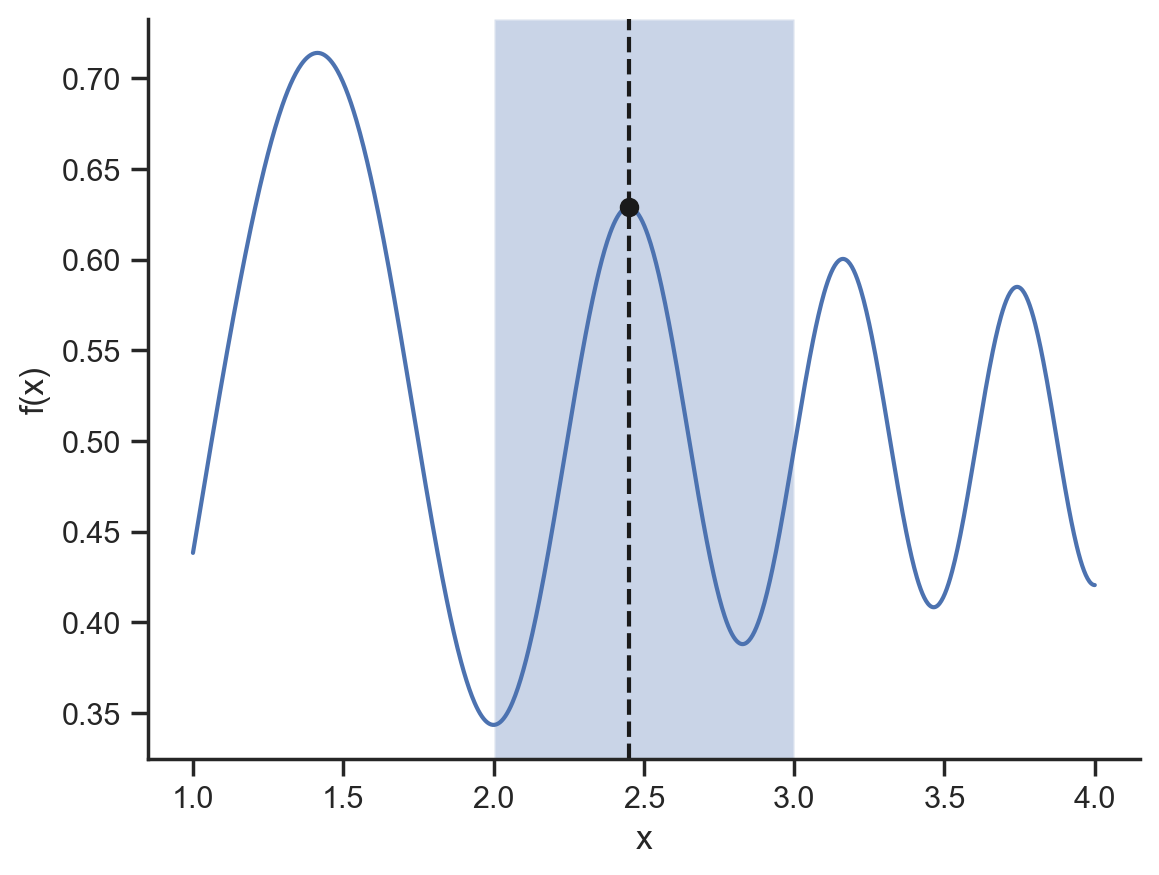

# References

- [`scipy.optimize` tutorial](http://docs.scipy.org/doc/scipy/reference/tutorial/optimize.html#univariate-function-minimizers-minimize-scalar)

## Colophon
This notebook was written by [Yoav Ram](http://python.yoavram.com) and is part of the [_Python for Engineers_](https://github.com/yoavram/Py4Eng) course.

The notebook was written using [Python](http://python.org/) 3.7.
Dependencies listed in [environment.yml](../environment.yml), full versions in [environment_full.yml](../environment_full.yml).

This work is licensed under a CC BY-NC-SA 4.0 International License.

![Python logo](https://www.python.org/static/community_logos/python-logo.png)